In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
import seaborn as sns
import os
# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

scanpy==1.8.2 anndata==0.7.5 umap==0.4.6 numpy==1.21.5 scipy==1.5.4 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.12.1 python-igraph==0.8.3


In [2]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import sys
sys.path.insert(0, '../')
import new_misc_code as nmc 

In [3]:
import hotspot
hotspot.__version__

'0.9.1'

# **Load data**

In [4]:
adata = sc.read( "../data/post-gaba-wt-dev-traj.h5ad")
adata.shape

(154748, 26747)

In [5]:
# remove poor quality cells
poor_mk = adata.obs['major_clust']=='Poor-Quality'
adata = adata[~poor_mk]
adata.shape

/scratchfs/cherring/brain_maturation/bm_project_env/hotspot_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(153473, 26747)

In [6]:
sc.pp.filter_genes( adata, min_cells=5)

Trying to set attribute `.var` of view, copying.


In [7]:
# select for HVGs using downsampled and normalized data
hvg_th = 5_000
sc.pp.highly_variable_genes( adata, n_top_genes=hvg_th, n_bins=20, flavor='seurat', inplace=True)

In [8]:
# select for HVGs
high_adata = adata[:,adata.var.highly_variable.values]
high_adata.shape

(153473, 5000)

In [9]:
# Hotspot will require the use of raw (non-downsampled) counts as well
adata.X = adata.layers['raw-cts_pre-ds'].copy()
raw = adata[:,adata.var.highly_variable.values]
raw.shape

(153473, 5000)

# **PCA**
PCA has already been ran just need to adjust to only use 50% of variation

In [10]:
# this number taken from previous notebook 3__whole-tissue_clustering.ipynb and is equal 50% of variation
comps = 365
pca = adata.obsm['X_pca'][:,:comps]

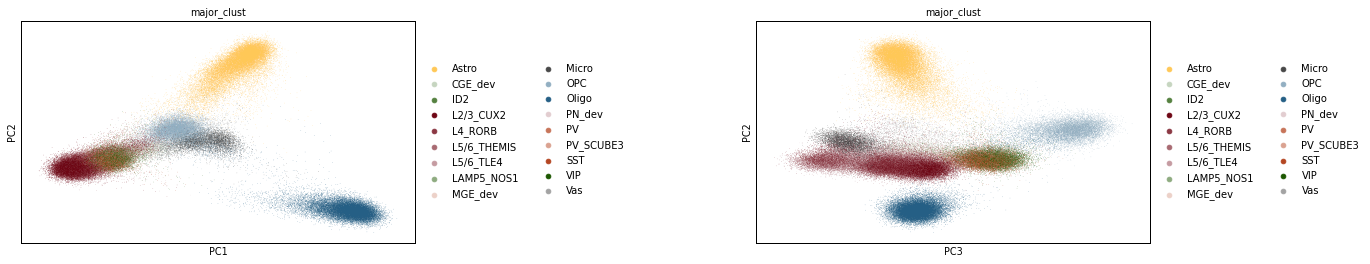

In [11]:
sc.pl.pca( high_adata, color=['major_clust'], components=['1,2','3,2'], legend_fontsize=10, wspace=0.70)

# **Hotspot**

In [12]:
# reformat data for hotspot
counts = raw.to_df()
counts = counts.T
lat_df = pd.DataFrame( pca, index=counts.columns)

In [13]:
# Create the Hotspot object and the neighborhood graph
hs = hotspot.Hotspot( counts, model='danb', latent=lat_df)

In [ ]:
# this will take a while to run, consider saving it if you would like repeated access to it. 
hs.create_knn_graph( weighted_graph=True, n_neighbors=25)

In [ ]:
hs_results = hs.compute_autocorrelations( jobs=25)
hs_results.head()

In [ ]:
nmc.save_obj( hs, "../data/hotspot.pkl")

In [21]:
adata.uns['major_clust_colors']

array(['#ffc857', '#c6d5c0', '#558140', '#6e0614', '#8b3843', '#a86a72',
       '#c59ba1', '#8eab80', '#ecd1c8', '#484848', '#92afc2', '#255f85',
       '#e2cdd0', '#c77459', '#daa290', '#b44622', '#1c5701', '#a3a3a3'],
      dtype=object)

In [22]:
# Select the genes with significant lineage autocorrelation                        
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).index

In [23]:
# Compute pair-wise local correlations between these genes
# This will also take quite a long while to run (>24hrs on 25 cores)
lcz = hs.compute_local_correlations( hs_genes, jobs=25)

Computing pair-wise local correlation on 4813 features...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11580078/11580078 [74:40:51<00:00, 43.07it/s]


In [ ]:
nmc.save_obj( hs, "../data/hotspot.pkl")

In [ ]:
# # Select the genes with significant lineage autocorrelation                        ################
# hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).index
#                                                                                    ################
# # Compute pair-wise local correlations between these genes
# lcz = hs.compute_local_correlations( hs_genes, jobs=90)

In [ ]:
# dta.save_obj( hs, "hotspot_data/hs_FULL-whole-tissue_pc365-feat-5k_NN25")
# lcz.to_csv( "hotspot_data/lcz_FULL-whole-tissue_pc365-feat-5k_NN25")

### Read in prior ran HOTSPOT session

In [ ]:
# hs = dta.load_obj( "/scratchfs/cherring/brain_maturation/analysis/data/hs_FULL-whole-tissue_pc365-feat-5k_NN25.pkl")

In [ ]:
### threshold of 25 works, 150 for large modules
modules = hs.create_modules(
    min_gene_threshold=65, core_only=True, fdr_threshold=0.05
)
modules.value_counts()

In [ ]:
### threshold of 25 works, 150 for large modules
modules = hs.create_modules(
    min_gene_threshold=65, core_only=True, fdr_threshold=0.05
)
modules.value_counts()

In [ ]:
modules

In [ ]:
hs.plot_local_correlations(vmin=-50, vmax=50)

In [ ]:
hs.plot_local_correlations(vmin=-50, vmax=50)

In [ ]:
module_scores = hs.calculate_module_scores()
module_scores.head()

In [ ]:
umap = adata.obsm['X_umap']

In [ ]:
 # subplot params
n    = max( hs.modules.unique())
cols = round( math.sqrt( n))
rows = math.ceil( n / cols)
size = cols * rows

fig, axs = plt.subplots( rows, cols, figsize=(rows*5,cols*5))
cax = fig.add_axes(
    [.95, .15, .007, .1]
)
for itr, (ax, mod) in enumerate( zip( axs.ravel(), hs.module_scores.columns)):
    ax.set_facecolor( 'white')
    scp = hs.module_scores[mod]
    vmin = -10
    vmax = 10
    plt.sca(ax)
    scp = plt.scatter(
        umap[:,0], umap[:,1],
        s=1, c=scp, vmin=vmin, vmax=vmax,
        rasterized=True, cmap='Blues')
    plt.xticks([])
    plt.yticks([])
    plt.title("Module {}".format(mod))
# clear rest of graphs
for ii in range( itr+1, size):
    ax = axs.flatten()[ii]
    ax.axis('off')
        
plt.subplots_adjust(hspace=0.2)
plt.colorbar(scp, cax=cax, label='Module\nScore')
plt.subplots_adjust(left=0.02, right=0.9)

In [ ]:
# rename modules to match order of paper
pap_dict = {14:'M1', 4:'M2', 11:'M3', 6:'M4', 7:'M5', 12:'M6', 3:'M7', 5:'M8', 1:'M9', 10:'M10', 2:'M11', 9:'M12', 8:'M13', 13:'M14', -1:'Not_Significant'}
pap_df = modules.to_frame()
pap_df.rename(columns={'Module':'Hotspot_ID'}, inplace=True)
pap_df['Hotspot_Module'] = [pap_dict[ii] for ii in pap_df['Hotspot_ID']]

In [ ]:
pap_df

In [ ]:
pap_df.to_csv( "/dd_userdata/usrdat03/userdata/cherring/data/cellranger_outputs/brain_maturation_RNA/output_data/Hotspot_gene_modules.csv")

### Check modules for negative correlation

In [ ]:
# to test for negative regulation need to comapare means for cluster1 (largest and oligo cluster) with mean from all cells not in oligo cluster, if more than oligo mean then I may have problems
# this test did not result in any genes in module 1 having higher mean expression outside of oligos than within oligos
# also checked module 2 with Micro and non are higher in than out
# so HOTSPOT only picks up positive correlations

In [ ]:
# get all modules in a dataframe
all_mods = hs.results.join(hs.modules)
all_mods.dropna( inplace=True)
# drop non assigned genes
all_mods = all_mods[all_mods['Module']!=-1.0]
all_mods.shape

In [ ]:
mod1_genes = all_mods[all_mods['Module']==3.0].index.values
olig_mk = adata.obs['major_clust']=='Astro'
for g_itr in mod1_genes:
    g_mk = adata.var_names==g_itr
    olig_mean = adata[olig_mk,g_mk].X.mean()
    other_mean = adata[~olig_mk,g_mk].X.mean()
    if( olig_mean<other_mean):
        print( g_itr)
#     print( sum( g_mk))

In [ ]:
olig_mean, other_mean

In [ ]:
sc.pl.umap( adata, color=['ADAM9','RRAD','MTRNR2L10','POMC'], size=6)

###  build matrix for heatmap - comparing major clusts across stages with modules

In [ ]:
np.unique( adata.obs['major_clust'].values)

In [ ]:
# reformat cluster names to fit preferred format of major clusters
sst_mk = adata.obs['major_clust']=='SST'
pv_mk  = adata.obs['major_clust']=='PV'
vip_mk = adata.obs['major_clust']=='VIP'
id2_mk = adata.obs['major_clust']=='ID2'
ca1_mk = adata.obs['sub_clust']=='LAMP5_CA1'
scb_mk = np.in1d( adata.obs['sub_clust'], ['PV_SCUBE3','PV_SCUBE3_dev'])

adata.obs['major_clust'] = adata.obs['major_clust'].astype(str)
adata.obs['major_clust'][sst_mk] = 'SST'
adata.obs['major_clust'][pv_mk ] = 'PV'
adata.obs['major_clust'][vip_mk] = 'VIP'
adata.obs['major_clust'][id2_mk] = 'ID2'
adata.obs['major_clust'][ca1_mk] = 'LAMP5_CA1'
adata.obs['major_clust'][scb_mk] = 'PV_SCUBE3'

np.unique( adata.obs['major_clust'].values)

In [ ]:
# get all modules in a dataframe
all_mods = hs.results.join(hs.modules)
all_mods.dropna( inplace=True)
# drop non assigned genes set to -1.0
all_mods = all_mods[all_mods['Module']!=-1.0]
all_mods.shape

In [ ]:
all_mods.to_csv('/dd_userdata/usrdat03/userdata/cherring/data/cellranger_outputs/brain_maturation_RNA/output_data/whole-tissue_all-cells_DEGs_hotspot-gene-modules.csv')

In [ ]:
stage_order = ['Fetal', 'Neonatal', 'Infancy', 'Childhood', 'Adolescence', 'Adult']
gene_names = adata.var_names.values

In [ ]:
# order clusters to paper styling
major_clusts = ['L2/3_CUX2', 'L4_RORB', 'L5/6_THEMIS', 'L5/6_TLE4', 'PN_dev',
                'VIP', 'ID2', 'LAMP5_CA1', 'CGE_dev',  
                'SST', 'PV', 'PV_SCUBE3', 'MGE_dev',  
                'Astro', 'Oligo', 'OPC',
                'Micro', 'Vas']

In [ ]:
# dataframe to hold cluster stage module expression
csme = pd.DataFrame([])
# loop through majors
for clust_itr in major_clusts:
    if( clust_itr=='Poor-Quality'):
        continue
    print( clust_itr)
    # take slice from adata data set
    adata_itr1 = adata[adata.obs['major_clust']==clust_itr]
    # loop through stages
    for stage_itr in stage_order:
        stage_mk = adata_itr1.obs['stage_ids']==stage_itr
        # only want to look at stages with over 10 cells in a cluster
        if( sum( stage_mk)<10):
            continue
        adata_itr2 = adata_itr1[stage_mk]
        ind_nm = f"{stage_itr}_{clust_itr}"
#         print( f"{ind_nm} shape is {adata_itr2.shape}")
        # loop through modules
        for mod_itr in all_mods['Module'].unique():
            if( int(mod_itr)==-1):
                continue
            mod_gene_mk = all_mods['Module']==mod_itr
            mod_genes = all_mods.index.values[mod_gene_mk]
            adata_gene_mk = np.array( dta.member_test( gene_names, mod_genes))
            gene_csr = adata_itr2[:,adata_gene_mk].X
            if( gene_csr.sum(0).sum()==0.0):
                print( f"nothing in {ind_nm}")
                csme.loc[ind_nm,f"Module-{str(int(mod_itr))}"] = 0.0
            else:
                gene_mean = gene_csr.mean(0)
                csme.loc[ind_nm,f"Module-{str(int(mod_itr))}"] = np.mean( gene_mean)

In [ ]:
cmap = sns.color_palette( "ch:start=.2,rot=-.3", n_colors=1000)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
#                                                                                                                                                     left_rigth,up/down,
g = sns.clustermap( csme.T, col_cluster=False, standard_scale=0, figsize=(40,8), cmap=cmap, yticklabels=csme.columns.values, linewidths=0.025, cbar_pos=(0.25, 0.925, 0.325, 0.05), 
                    cbar_kws={"orientation": "horizontal"})
g.ax_row_dendrogram.set_visible(False)
g.cax.set_visible(True)
plt.setp( g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig( "/dd_userdata/usrdat03/userdata/cherring/data/cellranger_outputs/brain_maturation_RNA/hotspot_dev-majclust-vs-modules.svg", format='svg')

## Get GO terms for each module

In [ ]:
# things to do to clean up module dev plot
# 1 read in non-downsampled data and use it for average expression
# 2 correct scanpy naming convention
# 3 change query back to symbol not ensg
# 4 set query background to genes expressed in whole tissue

#### Change gene symbols back from scanpy unique

In [ ]:
# check how many gene names are changed by scanpy var_names_make_unique()
gene_file = "/dd_userdata/usrdat03/userdata/cherring/data/cellranger_outputs/brain_maturation_RNA/RL1777_2d_v3/outs/filtered_feature_bc_matrix.h5"
test_adata = sc.read_10x_h5( gene_file)
raw_names = test_adata.var_names.values
raw_names

In [ ]:
test_adata.var_names_make_unique()
unq_names = test_adata.var_names.values.tolist()
current_names = all_mods.index.values.tolist()

In [ ]:
def get_preunique_names( current_names, raw_names=raw_names, unq_names=unq_names):
    raw_current_names = np.zeros_like( current_names)
    for itr, gene_itr in enumerate( current_names):
        if gene_itr not in raw_names:
            raw_current_names[itr] = raw_names[unq_names.index(gene_itr)]
        else:
            raw_current_names[itr] = gene_itr
    print( f"{len( current_names) - sum( dta.member_test( raw_current_names, current_names))} name changes")
    return( raw_current_names)

In [ ]:
all_mods.index = get_preunique_names( current_names)

In [ ]:
adata.var_names = get_preunique_names( adata.var_names)
gene_names = adata.var_names

#### Get list of background genes to submit to GO query

In [ ]:
gene_sums = (adata.X.sum(0)).A1
gene_mk1 = gene_sums>0
print( sum(gene_mk1))
background = gene_names[gene_mk1].values

In [ ]:
from gprofiler import GProfiler
def query_genes( genes, bk_grd=background.tolist(), p_thresh=0.05):
    gp = GProfiler( return_dataframe=True)
    query_df = gp.profile( organism='hsapiens', query=genes, user_threshold=p_thresh, background=bk_grd)
    ####################################################
    # only want moleuclar function and bio processes returned
    query_df = query_df[np.in1d( query_df['source'].values, ['GO:MF','GO:BP'])]
    ####################################################
    # only want less general GOs
#     parent_mk = np.array( [len( ii)>=parent_th for ii in query_df['parents'].values])
    return( query_df) #.loc[parent_mk])

In [ ]:
gos = {}
tfs = {}
pvs = {}
inter = {}
parents = {}
mods = np.unique( all_mods['Module'])
for mod_itr in mods:
    itr_mk = all_mods['Module']==mod_itr
    range_genes = all_mods.index.values[itr_mk]
    if( range_genes.size==0):
            gos[f"{ref_itr}_{c_itr}"] = []
            pvs[f"{ref_itr}_{c_itr}"] = []
            inter[f"{ref_itr}_{c_itr}"]  = []
    else:
        q_df = query_genes( range_genes.tolist(), p_thresh=0.999)
        gos[f"Module-{str(int(mod_itr))}"] = q_df["name"].values
        pvs[f"Module-{str(int(mod_itr))}"] = q_df["p_value"].values
        inter[f"Module-{str(int(mod_itr))}"] = q_df["intersection_size"].values
        parents[f"Module-{str(int(mod_itr))}"] = [len(ii) for ii in q_df['parents']]
gos

In [ ]:
# sort by parent level of go term
def get_lvl_gos( lvl_th, go_terms=gos, p_values=pvs, intersect=inter, parents=parents):
    lvl_gos = {}
    lvl_pvs = {}
    lvl_int = {}
    for key_itr in go_terms.keys():
        lvl_gos[key_itr] = [go for go, par in zip( go_terms[key_itr],  parents[key_itr]) if par==lvl_th]
        lvl_pvs[key_itr] = [pv for pv, par in zip( p_values[key_itr],  parents[key_itr]) if par==lvl_th]
        lvl_int[key_itr] = [te for te, par in zip( intersect[key_itr], parents[key_itr]) if par==lvl_th]
    return( lvl_gos, lvl_pvs, lvl_int)

In [ ]:
lvl1_gos, lvl1_pvs, lvl1_int = get_lvl_gos( 1)
lvl2_gos, lvl2_pvs, lvl2_int = get_lvl_gos( 2)
lvl3_gos, lvl3_pvs, lvl3_int = get_lvl_gos( 3)
lvl4_gos, lvl4_pvs, lvl4_int = get_lvl_gos( 4)

In [ ]:
# assumes go_dict is already sorted by p-value
def get_n_top_gos( go_dict, pv_dict, in_dict, N):
    top_g_dict = {}
    top_p_dict = {}
    top_i_dict = {}
    for k_itr in go_dict.keys():
        go_itr = go_dict[k_itr]
        pv_itr = pv_dict[k_itr]
        in_itr = in_dict[k_itr]
        top_g_dict[k_itr] = go_itr[:N]
        top_p_dict[k_itr] = pv_itr[:N]
        top_i_dict[k_itr] = in_itr[:N]
    return( top_g_dict, top_p_dict, top_i_dict)

In [ ]:
###################################################################
######### here is where you control level of GO terms
###################################################################
top_gos_dict, top_pvs_dict, top_int_dict = get_n_top_gos( lvl2_gos,lvl2_pvs, lvl2_int, 5)

In [ ]:
# create dataframe to hold p-values for mods and go terms
col_names = []
for vals in top_gos_dict.values():
    col_names = np.append( col_names, vals)
print( col_names.shape)
col_names = np.unique( col_names)
print( col_names.shape)

In [ ]:
gm_df = pd.DataFrame( [], index=list( top_gos_dict.keys()), columns=col_names, dtype=float)
in_df = pd.DataFrame( [], index=list( top_gos_dict.keys()), columns=col_names, dtype=int)
gm_df.iloc[:,:] = np.log10( 1.0)
in_df.iloc[:,:] = 0

In [ ]:
-np.log10(1.0), -np.log10( 0.05), -np.log10( 0.0000005)

In [ ]:
for mod_itr in gos.keys():
    pvs_itr = top_pvs_dict[mod_itr]
    gos_itr = top_gos_dict[mod_itr]
    for p_itr, go_itr in zip( pvs_itr, gos_itr):
        gm_df.loc[mod_itr,go_itr] = -np.log10( p_itr)    
        
for mod_itr in gos.keys():
    in_itr  = top_int_dict[mod_itr]
    gos_itr = top_gos_dict[mod_itr]
    for i_itr, go_itr in zip( in_itr, gos_itr):
        in_df.loc[mod_itr,go_itr] = i_itr

In [ ]:
gm_df.index.values

In [ ]:
#######################
ttt = 0.05
th = -np.log10(ttt)
# gm_df[gm_df>=th] = th
#######################

In [ ]:
sns.set(font_scale=0.70)
g = sns.clustermap( gm_df.T, col_cluster=True, figsize=(8,20), cmap=cmap, cbar_pos=(0.15, 0.825, 0.525, 0.012), 
                    cbar_kws={"orientation": "horizontal"}, linewidths=0.025)#, "ticks":-np.log10([1,0.05,0.005])})#, "ticklabels":["1.0", "0.05", "0.005"]})
g.ax_col_dendrogram.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
plt.setp( g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90);
plt.setp( g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
g.cax.set_visible( False)

In [ ]:
sns.set(font_scale=0.70)
g = sns.clustermap( gm_df, col_cluster=True, figsize=(20,8), cmap=cmap, cbar_pos=(0.15, 0.825, 0.525, 0.012), 
                    cbar_kws={"orientation": "horizontal"}, linewidths=0.025)#, "ticks":-np.log10([1,0.05,0.005])})#, "ticklabels":["1.0", "0.05", "0.005"]})
g.ax_col_dendrogram.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
plt.setp( g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90);
plt.setp( g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
g.cax.set_visible( False)
# plt.savefig( "/dd_userdata/usrdat03/userdata/cherring/data/cellranger_outputs/brain_maturation_RNA/hotspot_GOs-vs-modules.svg", format='svg')

In [ ]:
gm_df.to_csv( "/dd_userdata/usrdat03/userdata/cherring/data/cellranger_outputs/brain_maturation_RNA/hotspot_GOs-vs-modules_dataframe.csv")
in_df.to_csv( "/dd_userdata/usrdat03/userdata/cherring/data/cellranger_outputs/brain_maturation_RNA/hotspot_GOs-vs-modules_dataframe_intersect.csv")

## Extras

In [ ]:
 # subplot params
n    = max( hs.modules.unique())
cols = round( math.sqrt( n))
rows = math.ceil( n / cols)
size = cols * rows

fig, axs = plt.subplots( rows, cols, figsize=(rows*5,cols*5))
cax = fig.add_axes(
    [.95, .15, .007, .1]
)
for itr, (ax, mod) in enumerate( zip( axs.ravel(), hs.module_scores.columns)):
    ax.set_facecolor( 'white')
    scp = hs.module_scores[mod]
    vmin = -10
    vmax = 10
    plt.sca(ax)
    scp = plt.scatter(
        umap[:,0], umap[:,1],
        s=1, c=scp, vmin=vmin, vmax=vmax,
        rasterized=True, cmap='Blues')
    plt.xticks([])
    plt.yticks([])
    plt.title("Module {}".format(mod))
# clear rest of graphs
for ii in range( itr+1, size):
    ax = axs.flatten()[ii]
    ax.axis('off')
        
plt.subplots_adjust(hspace=0.2)
plt.colorbar(scp, cax=cax, label='Module\nScore')
plt.subplots_adjust(left=0.02, right=0.9)

In [ ]:
first_go = np.array( [f"{mods[itr]}--{ii[:10]}" for itr, ii in enumerate( gos)])
# first_go

In [ ]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

def get_row_order( fits):
    row_linkage = hierarchy.linkage(
        distance.pdist( fits, metric='euclidean'), method='average')
    leaf_order = hierarchy.leaves_list( row_linkage)
    return( leaf_order)

In [ ]:
import textwrap
cmap = sns.color_palette( "ch:start=.2,rot=-.3", n_colors=1000)
sns.set(font_scale=0.75)
ro = get_row_order( csme.T.values)
row_order = csme.T.index.values[ro]
ylabs = [first_go[int(ii)-1] for ii in row_order]
g = sns.clustermap( csme.T.loc[row_order,:], col_cluster=False, standard_scale=0, figsize=(15,25), cmap=cmap, square=False, yticklabels=[textwrap.fill(e, 50) for e in ylabs])

In [ ]:
sc.settings.set_figure_params( dpi=80, fontsize=6, color_map='cool')
for itr in np.random.randint( 0, hs.neighbors.shape[0], size=10):
    t_mk = np.array( [ii in hs.neighbors.iloc[itr,:].values for ii in range(adata.shape[0])])
    adata.obs['test'] = t_mk
    sc.pl.embedding( adata, basis='umap', color=['test'], legend_fontsize=4, add_outline=False, size=15, legend_fontoutline=0.2, sort_order=True)